# Flipping USB Connectors


*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

[Click here to run this article on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/usb.ipynb)

I am not the first person to observe that it sometimes takes several tries to plug in a USB connector (specifically the rectangular [Type A connector](https://en.wikipedia.org/wiki/USB), which is not reversible).
There are [memes about it](https://knowyourmeme.com/memes/usb-insertion-issues), there are [cartoons about it](https://www.smbc-comics.com/?id=2388), and on Quora alone,
[people](https://www.quora.com/Why-do-you-always-have-to-flip-a-USB-twice-when-trying-to-plug-it-in-Shouldn-t-it-have-gone-in-the-first-time-when-you-had-it-the-right-way)
[have](https://www.quora.com/There-is-a-50-chance-of-plugging-in-a-USB-cable-the-right-way-on-the-first-try-Why-does-it-only-happen-20-of-the-time-when-I-do-it)
[asked](https://www.quora.com/Why-doesnt-the-USB-go-in-the-first-time-but-does-after-youve-turn-it-a-few-times)
[about](https://www.quora.com/People-that-can-plug-the-USB-in-on-their-first-try-How)
[it](https://www.quora.com/Why-cant-we-plug-in-USB-devices-correctly-the-first-time) more than once.

But I might be the first to use Bayesian decision analysis to figure out the optimal strategy for plugging in a USB connector. Specifically, I have worked out how long you should try on the first side before flipping, how long you should try on the second side before flipping again, how long you should try on the third side, and so on.

Of course, my analysis is based on some modeling assumptions:

1. Initially, the probability is 0.5 that the connector is in the right orientation.

2. If it is, the time it takes to succeed follows an exponential distribution with a mean of 1.1 seconds.

3. Flipping the connector takes 0.1 seconds.

With that, we are ready to get started.

## Continuous Updates

The first step is to figure out the probability that the connector is in the right orientation as a function of how long you have been trying.
For that, we can use a Bayes table, which is a form of Bayes's Theorem I use in [Chapter 2 of *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap02.html#bayes-tables).

The following function takes a sequence of hypotheses, prior probabilities, and likelihoods, and returns a pandas `DataFrame` that represents a Bayes table.

In [1]:
import pandas as pd

def bayes_table(hypos, prior, likelihood):
    """Make a table showing a Bayesian update."""
    table = pd.DataFrame(dict(prior=prior, likelihood=likelihood), index=hypos)
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return table

Now suppose that the prior probability is 0.5 that the orientation of the connector is correct, and you have been trying for 0.9 seconds.
What is the likelihood that you would have to try so long?

* If you are on the wrong side, it is 100%.

* If you are on the right side, it's given by the survival function (complementary CDF) of the exponential distribution, which is $\exp(-\lambda t)$, where $\lambda$ is the rate parameter and $t$ is time.

The following function computes this likelihood:

In [2]:
import numpy as np

def expo_sf(t, lam):
    """Survival function of the exponential distribution."""
    return np.exp(-lam * t)

We can use this function to compute the likelihood of trying for 0.9 seconds or more, given an exponential distribution with mean 1.1.

In [3]:
t = 0.9
mu = 1.1
lam = 1/mu

expo_sf(t, lam)

0.441233167759984

The result is the likelihood of the data, given that the orientation of the connector is correct.

Now let's make a Bayes table with two hypotheses -- the connector is either the right way or the wrong way -- with equal prior probabilities.

In [4]:
hypos = ['Right way', 'Wrong way']
prior = [1/2, 1/2]

And here is the likelihood of the data for each hypothesis:

In [5]:
likelihood = [expo_sf(t, lam), 1]

Putting it together, here's the Bayes table.

In [6]:
bayes_table(hypos, prior, likelihood)

,prior,likelihood,unnorm,posterior
Right way,0.5,0.441233,0.220617,0.30615
Wrong way,0.5,1.000000,0.500000,0.69385


After 0.9 seconds, the probability is about 69% that the orientation of the connector is wrong, so you might want to think about trying the other side.

But if it takes 0.1 seconds to flip, maybe you should keep trying a little longer. To figure out when to flip, let's do the same analysis again for general values of $\lambda$ and $t$.

## Generalization

To minimize human error, I'll use Sympy to do the algebra. Here are the symbols I'll use.

In [7]:
from sympy import symbols, exp

t, lam, p, q, r = symbols('t lam p q r')

Here's the likelihood again, using the symbols.

In [8]:
likelihood = [exp(-lam * t), 1]
likelihood

[exp(-lam*t), 1]

And here's the Bayes table, using $p$ and $q$ for the prior probabilities of the hypotheses.

In [9]:
prior = [p, q]
table = bayes_table(hypos, prior, likelihood)
table

,prior,likelihood,unnorm,posterior
Right way,p,exp(-lam*t),p*exp(-lam*t),p*exp(-lam*t)/(p*exp(-lam*t) + q)
Wrong way,q,1,q,q/(p*exp(-lam*t) + q)


From the table I'll select the posterior probability that the orientation is correct.

In [10]:
expr = table.loc['Right way', 'posterior']
expr.simplify()

p/(p + q*exp(lam*t))

You might recognize this as a form of the [logistic function](https://en.wikipedia.org/wiki/Logistic_function); we can compute it like this:

In [11]:
def logistic(p, lam, t):
    q = 1-p
    return p / (p + q * np.exp(lam * t))

Let's see what that looks like for a range of values of `t`, assuming that the prior probability is `p=0.5`.

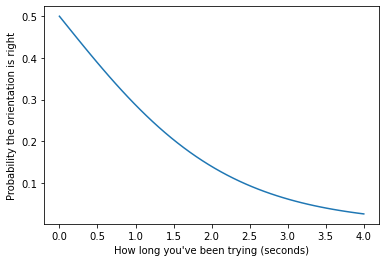

In [12]:
import matplotlib.pyplot as plt

ts = np.linspace(0, 4)
ps = logistic(p=0.5, lam=1/mu, t=ts)

plt.plot(ts, ps)
plt.xlabel("How long you've been trying (seconds)")
plt.ylabel("Probability the orientation is right");

After a few seconds of fiddling, you should be reasonably convinced that the orientation is wrong.

## Strategy

Now, let's think about turning belief into action. Let me start with a conjecture: I suspect that the best strategy is to try on the first side until the probability of correct orientation drops below some threshold (to be determined), then try on the second side until the probability drops below that threshold again, and repeat until success.

To test this strategy, we will have to figure out how long to try as a function of the prior probability, `p`, and the threshold probability, `r`. Again, I'll make Sympy do the work.

Here's the equation that sets the posterior probability, which we computed in the previous section, to `r`.

In [13]:
from sympy import Eq, solve

eqn = Eq(expr, r)
eqn

Eq(p*exp(-lam*t)/(p*exp(-lam*t) + q), r)

And here's the solution for `t` in terms of `p`, `q`, `r`, and `lam`.

In [14]:
solve(eqn, t)[0]

log(p*(1 - r)/(q*r))/lam

And here's how we can express this solution in terms of the prior and posterior odds.

In [15]:
def wait_time(p, lam, r):
    q = 1-p
    prior_odds = p / q
    posterior_odds = r / (1-r)
    return np.log(prior_odds / posterior_odds) / lam

Let's see what that looks like for a range of values of `r`, assuming that the prior probability is `p=0.5`.

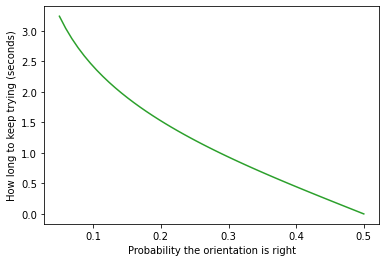

In [16]:
rs = np.linspace(0.05, 0.5)
ts = wait_time(p=0.5, lam=1/mu, r=rs)

plt.plot(rs, ts, color='C2')
plt.xlabel("Probability the orientation is right")
plt.ylabel("How long to keep trying (seconds)");

When the threshold is low, we have to wait a few seconds to reach it. As the threshold increases, the time to reach it decreases.
We'll use this function in the next section to simulate the strategy.

## Simulation

As a step toward optimization, let's run a simulation. The following function takes as parameters:

* `correct`: A Boolean indicating if the orientation is correct.
* `p`: The prior probability that the orientation is correct.
* `lam`: The rate parameter for the distribution of time until success.
* `r`: The threshold for the posterior probability.
* `flip`: The time it takes to flip the connector, in seconds.
* `trace`: A list that indicates how much time we have spent, so far, trying and flipping.

It runs the simulation and returns a sequence of waiting and flipping times. The sum of this sequence is the total time it took to connect. And we can use the length of the sequence to figure out how many times we had to flip.

In [17]:
def simulate(correct, p, lam, r, flip, trace):
    # figure out the maximum time we should try before flipping
    wait = wait_time(p, lam, r)
    
    # if we're on the correct side, see if we succeed before time's up
    if correct:
        t = np.random.exponential(1/lam)
        if t < wait:
            # if so, update and return the trace
            return trace + [t]
    
    # if time expired, add the wait time and flip time to the trace  
    # and make a recursive call to continue the simulation
    return simulate(not correct, 1-r, lam, r, flip, trace + [wait, flip])

Here's a test run, starting on the correct side.

In [18]:
simulate(correct=True, p=0.5, lam=1/mu, r=0.2, flip=0.1, trace=[])

[1.5249237972318797, 0.1, 3.0498475944637597, 0.1, 0.22920261920526902]

And here's a run where we start on the wrong side.

In [19]:
simulate(correct=False, p=0.5, lam=1/mu, r=0.2, flip=0.1, trace=[])

[1.5249237972318797, 0.1, 0.8744612650971085]

The following function runs the simulation many times with initial probability `p=0.5`, starting in the right orientation half the time.

It returns two arrays, containing the length of the trace and the total duration for each simulation.

In [20]:
def run_simulations(lam, r, flip, iters=20000, flag=None):
    res = []
    for i in range(iters):
        correct = i%2 if flag is None else flag
        trace = simulate(correct, 0.5, lam, r, flip, [])
        res.append((len(trace), sum(trace)))
        
    return np.transpose(res)

Here's the average total duration with threshold probability `r=0.25`.

In [21]:
lengths, totals = run_simulations(lam=1/mu, r=0.25, flip=0.1)
totals.mean()

2.403304555631497

With this threshold, it takes about 2 seconds to connect, on average.

## Optimization

Now let's see how the average duration varies as we sweep through a range of values for the threshold probability, `r`:

In [22]:
rs = np.linspace(0.15, 0.4, 21)
rs

array([0.15  , 0.1625, 0.175 , 0.1875, 0.2   , 0.2125, 0.225 , 0.2375,
       0.25  , 0.2625, 0.275 , 0.2875, 0.3   , 0.3125, 0.325 , 0.3375,
       0.35  , 0.3625, 0.375 , 0.3875, 0.4   ])

In [23]:
np.random.seed(17)

res = []
for r in rs:
    lengths, totals = run_simulations(lam=1/mu, r=r, flip=0.1)
    res.append((r, totals.mean()))

In [24]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [25]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

Here's what the results look like.

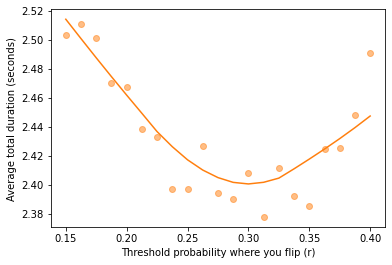

In [26]:
rs, ts = np.transpose(res)
series = pd.Series(ts, rs)

plot_series_lowess(series, 'C1')

plt.xlabel("Threshold probability where you flip (r)")
plt.ylabel("Average total duration (seconds)");

The optimal value of `r` is close to `0.3`. With that threshold we can see how long we should try on the first side, starting with prior probability `p=0.5`.

In [27]:
r_opt = 0.3
wait_time(p=0.5, lam=1/mu, r=r_opt)

0.9320276464259238

With the given values of `lam` and `flip`, it turns out the optimal time to wait is about `0.9` seconds.

If we have to flip, the prior probability for the second side is `p=1-r`, so we have to wait twice as long for the posterior probability to get down to `r`.

In [28]:
wait_time(p=1-r_opt, lam=1/mu, r=r_opt)

1.864055292851848

## How many flips?

Now let's run the simulations with the optimal value of `r` and see what the distributions look like for the total time and the number of flips.

In [29]:
lengths1, totals1 = run_simulations(lam=1/mu, r=r_opt, flip=0.1, flag=True)
lengths2, totals2 = run_simulations(lam=1/mu, r=r_opt, flip=0.1, flag=False)

Here's the distribution of total time, represented as a CDF.

In [30]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

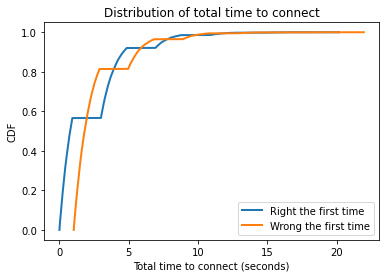

In [31]:
from empiricaldist import Cdf

Cdf.from_seq(totals1).plot(lw=2, label='Right the first time')
Cdf.from_seq(totals2).plot(lw=2, label='Wrong the first time')

plt.xlabel('Total time to connect (seconds)')
plt.ylabel('CDF')
plt.title('Distribution of total time to connect')
plt.legend();

In [32]:
totals1.mean(), totals2.mean()

(2.2006236558767154, 2.616228241925388)

In [33]:
np.append(totals1, totals2).mean()

2.4084259489010518

The average is about 2.4 seconds, but occasionally it takes much longer!

And here's the distribution for the total number of flips.

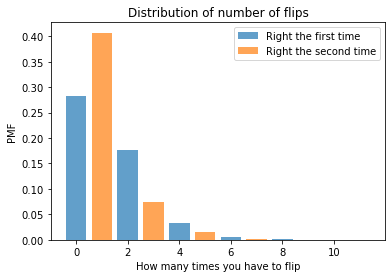

In [34]:
from empiricaldist import Pmf

flips1 = (lengths1-1) // 2
pmf1 = Pmf.from_seq(flips1) / 2
pmf1.bar(alpha=0.7, label='Right the first time')

flips2 = (lengths2-1) // 2
pmf2 = Pmf.from_seq(flips2) / 2
pmf2.bar(alpha=0.7, label='Right the second time')

plt.xlabel('How many times you have to flip')
plt.ylabel('PMF')
plt.title('Distribution of number of flips')
plt.legend();

In [35]:
lengths = np.append(lengths1, lengths2)
flips = (lengths-1) // 2
Pmf.from_seq(flips).head(5)

,probs
0.0,0.282925
1.0,0.407050
2.0,0.177200
3.0,0.075200
4.0,0.032575


The probability of getting it right on the first try is only about 28%. That might seem low, because the chance of starting in the right orientation is 50%, but remember that we have a substantial chance of flipping even if we start in the right orientation (and in that case, we have to flip at least twice).

The most common outcome is that we have to flip once, about 40% of the time. And the probability of the notorious double flip is about 18%. 

Fortunately, it is rare to flip three or more times.

## Summary

With that, I think we have solved the USB connector problem.

1. For given parameters `lam` and `flip`, we can find the threshold probability, `r`, that minimizes the average time to connect.

2. Given this optimal value, we can estimate the distribution of total time and the number of times we have to flip.

Sadly, all of this fun is gradually being spoiled by the encroachment of the [USB-C](https://en.wikipedia.org/wiki/USB-C) connector, which is reversible.

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

Copyright 2021 Allen Downey

Code: [MIT License](https://opensource.org/licenses/MIT)

Text: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)